In [1]:
# Basic Setup
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LassoCV
import collections
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read Data
training_data = pd.read_csv('adult.data', sep=',', header=None)
attributes_names = ['Age', 'Workclass','Fnlwgt','Education','Education_Num','Marital_Status',
                    'Occupation','Relationship','Race','Sex','Capital_Gain','Capital_Loss',
                    'Hours_Per_Week','Native_Country','Income']
training_data.columns = attributes_names
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   Fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Marital_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_Per_Week  32561 non-null  int64 
 13  Native_Country  32561 non-null  object
 14  Income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [3]:
object_columns = ['Workclass', 'Education', 'Marital_Status', 'Occupation',
                          'Relationship', 'Race', 'Sex', 'Native_Country', 'Income']

# remove unknown value ('?')
for str_col in object_columns:
    training_data = training_data[training_data[str_col] != ' ?']
    
#assign numerical value for categorical value
numerical_training_data = training_data.copy()
for str_col in object_columns:
    numerical_training_data[str_col] = numerical_training_data[str_col].astype('category').cat.codes
    
    
print('Number of data in dataset after removing unkown value:\t', len(numerical_training_data))

# record numerical value for categorical value in each object attribute
corresponding_attributes = {}
for j in (1, 3, 5, 6, 7, 8, 9, 13):
    dic, numerical_list = {}, list(numerical_training_data[attributes_names[j]])
    for i, temp_str in enumerate(list(training_data[attributes_names[j]])):
        if temp_str.strip() not in dic:
            dic[temp_str.strip()] = numerical_list[i]
    corresponding_attributes[j] = dic
print(corresponding_attributes)
print(numerical_training_data)

Number of data in dataset after removing unkown value:	 30162
{1: {'State-gov': 5, 'Self-emp-not-inc': 4, 'Private': 2, 'Federal-gov': 0, 'Local-gov': 1, 'Self-emp-inc': 3, 'Without-pay': 6}, 3: {'Bachelors': 9, 'HS-grad': 11, '11th': 1, 'Masters': 12, '9th': 6, 'Some-college': 15, 'Assoc-acdm': 7, '7th-8th': 5, 'Doctorate': 10, 'Assoc-voc': 8, 'Prof-school': 14, '5th-6th': 4, '10th': 0, 'Preschool': 13, '12th': 2, '1st-4th': 3}, 5: {'Never-married': 4, 'Married-civ-spouse': 2, 'Divorced': 0, 'Married-spouse-absent': 3, 'Separated': 5, 'Married-AF-spouse': 1, 'Widowed': 6}, 6: {'Adm-clerical': 0, 'Exec-managerial': 3, 'Handlers-cleaners': 5, 'Prof-specialty': 9, 'Other-service': 7, 'Sales': 11, 'Transport-moving': 13, 'Farming-fishing': 4, 'Machine-op-inspct': 6, 'Tech-support': 12, 'Craft-repair': 2, 'Protective-serv': 10, 'Armed-Forces': 1, 'Priv-house-serv': 8}, 7: {'Not-in-family': 1, 'Husband': 0, 'Wife': 5, 'Own-child': 3, 'Unmarried': 4, 'Other-relative': 2}, 8: {'White': 4, 'Bl

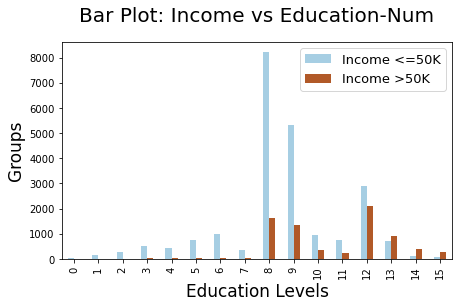

In [4]:
# Plot Group 1 - Income vs Education Level

# Box Plot
# get the education levels and count how many groups are in each level
less = numerical_training_data[numerical_training_data['Income'] == 0]
more = numerical_training_data[numerical_training_data['Income'] == 1]
less_than_50k = less['Education_Num'].value_counts().to_dict()
more_than_50k = more['Education_Num'].value_counts().to_dict()
# print(less)
# print(more_than_50k)

# fill the Count Dataframe if there exists key(s) that has(have) 0 value
for i in range(1, 17):
    if i not in less_than_50k:
        less_than_50k[i] = 0
for i in range(1, 17):
    if i not in more_than_50k:
        more_than_50k[i] = 0

# print(sorted(less_than_50k.items(), key = lambda x: x[0]))
# print(more_than_50k)   

# extract the values of groups
less_than_50k = sorted(less_than_50k.items(), key=lambda x: x[0])
more_than_50k = sorted(more_than_50k.items(), key=lambda x: x[0])
less_than_50k_values = [value for key, value in less_than_50k]
more_than_50k_values = [value for key, value in more_than_50k]

# plot the graph
df = pd.DataFrame({'Income <=50K': less_than_50k_values, 'Income >50K': more_than_50k_values})
df.plot(kind="bar", colormap='Paired', figsize=(7,4))

plt.title("Bar Plot: Income vs Education-Num", fontsize=20, pad=20)
plt.legend(loc=1, prop={'size': 13})
plt.xlabel("Education Levels", fontsize=17)
plt.ylabel("Groups", fontsize=17)
plt.show()

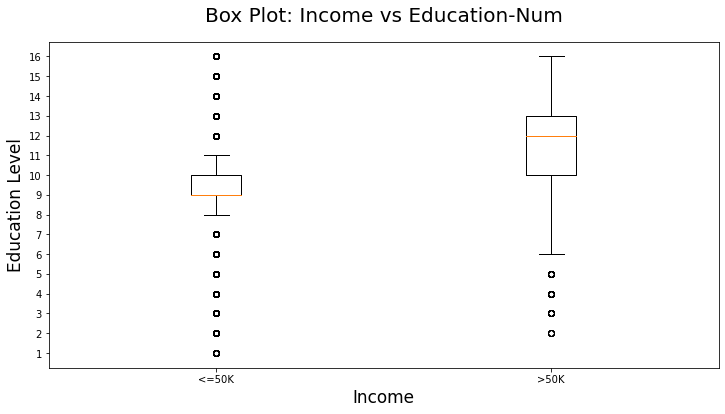

In [5]:
# Box-Whisker Plot

df_less_than_50k = numerical_training_data[numerical_training_data['Income'] == 0]
df_more_than_50k = numerical_training_data[numerical_training_data['Income'] == 1]

# plot and show the range of education levels of two different income groups
fig, ax = plt.subplots(figsize=(12,6))
dataset = [df_less_than_50k["Education_Num"], df_more_than_50k["Education_Num"]]
labels = ["<=50K",">50K"]
ax.boxplot(dataset, labels=labels)

plt.yticks(range(1,17,1))
plt.xlabel("Income", fontsize=17)
plt.ylabel("Education Level", fontsize=17)
plt.title("Box Plot: Income vs Education-Num", fontsize=20, pad=20)
plt.show()

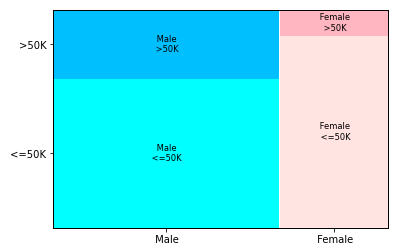

In [6]:
# Plot 2 - Income vs Sex (Mosaic Plot)
from statsmodels.graphics.mosaicplot import mosaic

cols = {(" Male", " <=50K"):'#00FFFF', (' Male',' >50K'):'#00BFFF',(' Female',' <=50K'):'#FFE4E1', (' Female',' >50K'):'#FFB6C1'}
mosaic(training_data, ["Sex","Income"], properties=lambda key:{'color':cols[key]})
plt.show()

In [7]:
# Additional cell used to polt

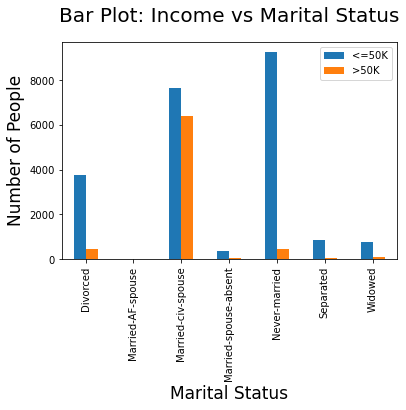

In [8]:
# Plot Group 2 - Income vs Marital Status (Bar Chart)
# 5: {'Never-married': 4, 'Married-civ-spouse': 2, 'Divorced': 0, 'Married-spouse-absent': 3, 'Separated': 5, 'Married-AF-spouse': 1, 'Widowed': 6}
mari_less_than_50k = {}
mari_more_than_50k = {}
for i in range(0, 7):
    less_count = 0
    more_count = 0
    for j in numerical_training_data.index:
        if numerical_training_data["Marital_Status"][j] == i:
            if numerical_training_data["Income"][j] == 0:
                less_count += 1
            else:
                more_count += 1
    mari_less_than_50k[i] = less_count
    mari_more_than_50k[i] = more_count
mari_less_than_50k = pd.DataFrame.from_dict(mari_less_than_50k, orient='index')
mari_more_than_50k = pd.DataFrame.from_dict(mari_more_than_50k, orient='index')
mari_income_df = pd.concat([mari_less_than_50k, mari_more_than_50k], axis=1, join='inner')
mari_income_df.columns = ['<=50K', '>50K']
# print(mari_income_df)
bars = ('Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed')
x_pos = np.arange(len(bars))
mari_income_df.plot(y=['<=50K', '>50K'], kind="bar")
plt.title("Bar Plot: Income vs Marital Status", fontsize=20, pad=20)
plt.xlabel("Marital Status", fontsize=17)
plt.ylabel("Number of People", fontsize=17)
plt.xticks(x_pos, bars)
plt.show()

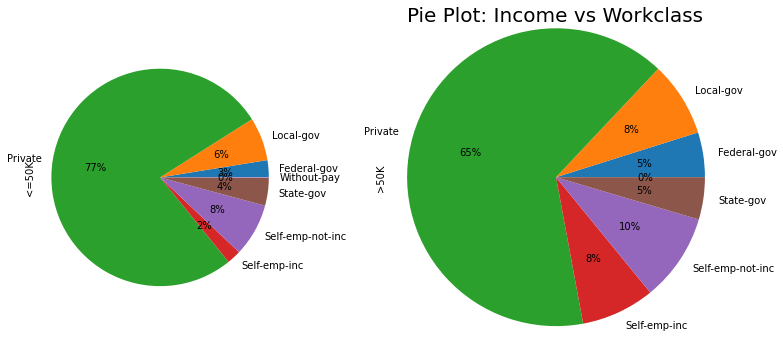

In [9]:
# Plot Group 2 - Income vs Workclass (Pie Chart)
# 1: {'State-gov': 5, 'Self-emp-not-inc': 4, 'Private': 2, 'Federal-gov': 0, 'Local-gov': 1, 'Self-emp-inc': 3, 'Without-pay': 6}
workclass_less_than_50k = {}
workclass_more_than_50k = {}
for i in range(0, 7):
    less_count = 0
    more_count = 0
    for j in numerical_training_data.index:
        if numerical_training_data["Workclass"][j] == i:
            if numerical_training_data["Income"][j] == 0:
                less_count += 1
            else:
                more_count += 1
    workclass_less_than_50k[i] = less_count
    workclass_more_than_50k[i] = more_count
workclass_less_than_50k = pd.DataFrame.from_dict(workclass_less_than_50k, orient='index')
workclass_more_than_50k = pd.DataFrame.from_dict(workclass_more_than_50k, orient='index')
workclass_income_df = pd.concat([workclass_less_than_50k, workclass_more_than_50k], axis=1, join='inner')
workclass_income_df.columns = ['<=50K', '>50K']
# print(workclass_income_df)
labels = 'Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'
workclass_income_df.plot.pie(labels=labels, subplots=True, figsize=(13,5), autopct='%1.0f%%', legend=False)
plt.title('Pie Plot: Income vs Workclass', fontsize=20, pad=20)
plt.axis('equal')
plt.show()

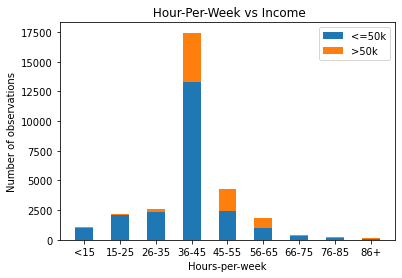

In [10]:
# Plot Group 3 - Hour-Per-Week vs Income
df_less_than_50k = numerical_training_data[numerical_training_data['Income'] == 0]
df_more_than_50k = numerical_training_data[numerical_training_data['Income'] == 1]

bins = [0, 15, 25, 35, 45, 55, 65, 75, 85, np.inf]
labels = ['<15', '15-25', '26-35', '36-45', '45-55', '56-65', '66-75','76-85','86+']
df_less_than_50k  = df_less_than_50k .groupby(['Income', pd.cut(df_less_than_50k ['Hours_Per_Week'], bins)])
df_more_than_50k = df_more_than_50k.groupby(['Income', pd.cut(df_more_than_50k['Hours_Per_Week'], bins)])
df_less_than_50k = df_less_than_50k.size()
df_more_than_50k = df_more_than_50k.size()
width = 0.50
fig, ax = plt.subplots()
ax.bar(labels, df_less_than_50k, width, label='<=50k')
ax.bar(labels,df_more_than_50k, width, bottom=df_less_than_50k,label='>50k')
plt.xlabel("Hours-per-week")
plt.ylabel("Number of observations")
plt.title(" Hour-Per-Week vs Income")
ax.legend()
plt.show()

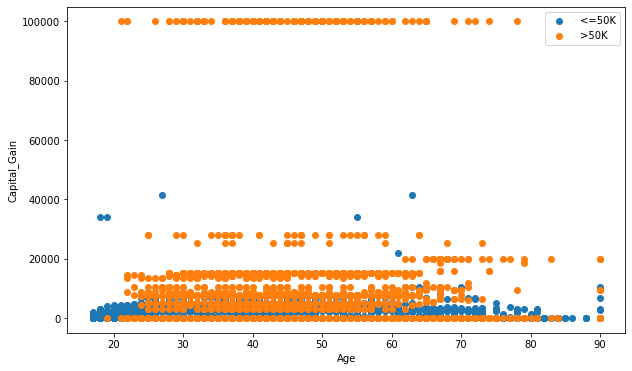

In [11]:
# Plot Group 3 - Age&Capital_Gain VS Income (Scatter Plot)
df_less_than_50k = numerical_training_data[numerical_training_data['Income'] == 0]
df_more_than_50k = numerical_training_data[numerical_training_data['Income'] == 1]

plt.figure(figsize=(10,6))
plt.scatter(df_less_than_50k['Age'], df_less_than_50k['Capital_Gain'])
plt.scatter(df_more_than_50k['Age'], df_more_than_50k['Capital_Gain'])
plt.legend(training_data['Income'].value_counts().index.tolist())
plt.xlabel("Age")
plt.ylabel("Capital_Gain")
plt.show()

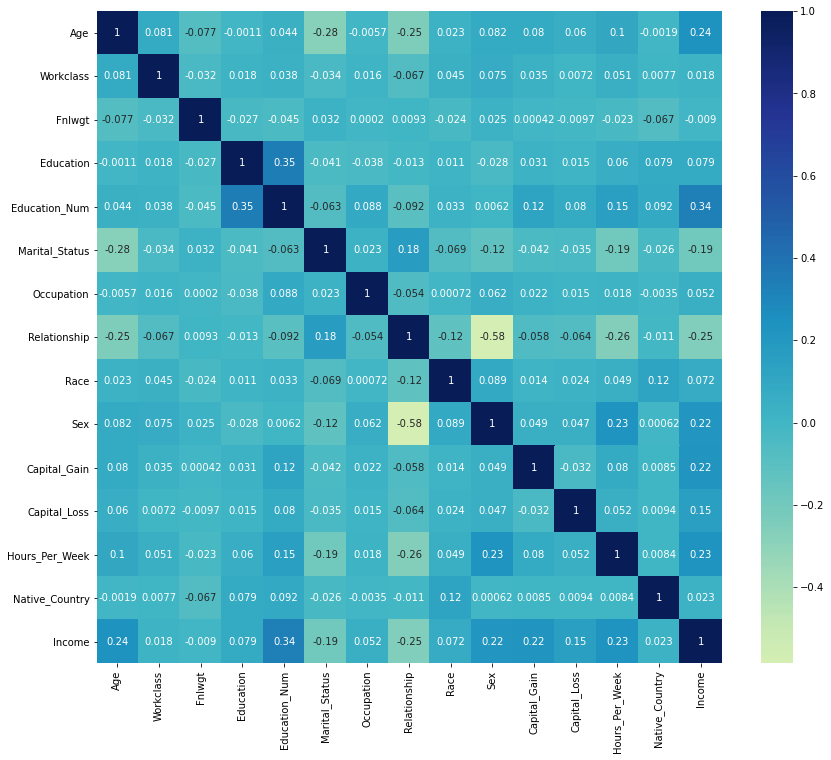

In [12]:
# Plot Group 4 - Heatmap for Correlation between Attributes
plt.figure(figsize=(14,12))
sns.heatmap(numerical_training_data.corr(),annot=True, cmap="YlGnBu", center = 0)
plt.show()

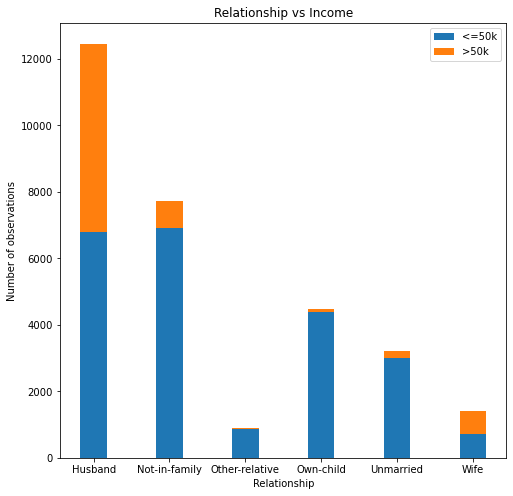

In [13]:
# Plot Group 4 - Bar chart for Relationship vs Income
rela_dic = sorted(corresponding_attributes[7].items(), key=lambda x: x[1])
labels = [it[0] for it in rela_dic]
# print(labels)

less = numerical_training_data[numerical_training_data['Income'] == 0]
more = numerical_training_data[numerical_training_data['Income'] == 1]
less_than_50k = less['Relationship'].value_counts().to_dict()
more_than_50k = more['Relationship'].value_counts().to_dict()
less_than_50k = sorted(less_than_50k.items(), key=lambda x: x[0])
more_than_50k = sorted(more_than_50k.items(), key=lambda x: x[0])
less_than_50k = [it[1] for it in less_than_50k]
more_than_50k = [it[1] for it in more_than_50k]

plt.rcParams["figure.figsize"]=(8,8)
width = 0.35 
fig, ax = plt.subplots()
ax.bar(labels, less_than_50k, width, label='<=50k')
ax.bar(labels, more_than_50k, width, bottom=less_than_50k,label='>50k')
plt.xlabel("Relationship")
plt.ylabel("Number of observations")
plt.title("Relationship vs Income")
ax.legend()
plt.show()

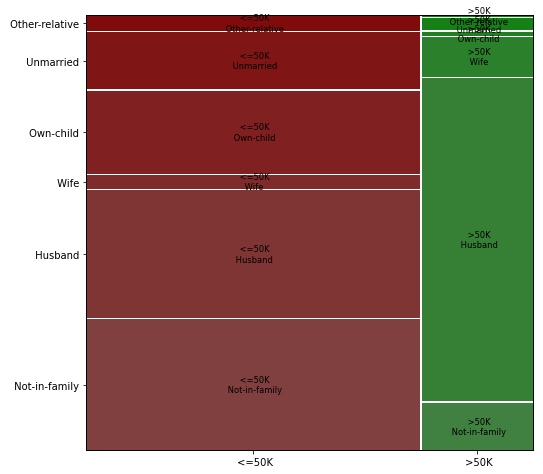

In [14]:
# Plot Group 4 - Mosaic plot for Relationship vs Income
# plt.rcParams["figure.figsize"]=(18,18)
mosaic(training_data, ['Income','Relationship'])
plt.show()

<AxesSubplot:xlabel='Relationship', ylabel='Hours_Per_Week'>

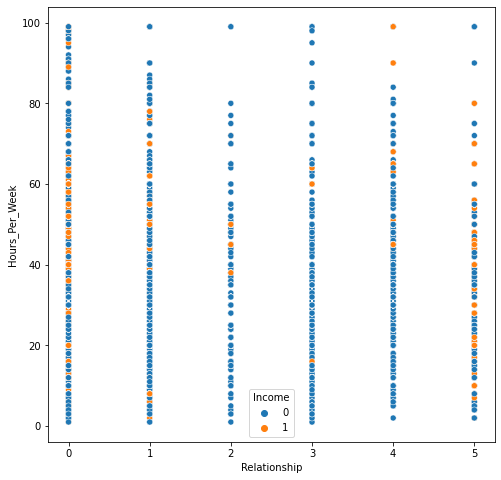

In [15]:
# Plot Group 4 - scatter plot for Relationship vs Income
sns.scatterplot(data=numerical_training_data, x="Relationship", y="Hours_Per_Week", hue="Income")

In [16]:
print(1)

1


In [17]:
print(1)

1


In [18]:
print(1)

1


In [19]:
print(1)

1


In [20]:
print(1)

1


In [21]:
print(1)

1


In [22]:
print(1)

1


In [23]:
print(1)

1


Prediction:

In [24]:
def load_test_data(corresponding_attributes):
    inputs, expected_output = [],[]
    # print(corresponding_attributes)
    with open('adult.test', 'r') as myfile:
        myfile.readline()         # flush the first line
        line = myfile.readline()[:-2]      # ignore '.' and '\n'
        while line and line != '\n':
            temp_list = line.split(', ')
            inputs_list, output_label = temp_list[:-1], temp_list[-1]
            check_for_question_mark = False
            for index, dic in corresponding_attributes.items():
                if inputs_list[index].strip() == '?':
                    check_for_question_mark = True
                    break
                if inputs_list[index].strip() in dic:
                    inputs_list[index] = dic[inputs_list[index]]  
            if check_for_question_mark:
                line = myfile.readline()[:-2]
                continue
            if output_label.strip() == '<=50K':
                expected_output.append(0)
            else:
                expected_output.append(1)
            inputs.append(inputs_list)
            line = myfile.readline()[:-2]
    return np.array(inputs, dtype='int'), np.array(expected_output, dtype='int')

training_inputs, training_class_labels = numerical_training_data.drop(columns=['Income']).to_numpy(dtype='int'), numerical_training_data['Income'].to_numpy(dtype='int')
testing_inputs, testing_output = load_test_data(corresponding_attributes)

# normalize data, ensure the range for each attribute are same
training_inputs = StandardScaler().fit_transform(training_inputs)
testing_inputs = StandardScaler().fit_transform(testing_inputs)

Naive Bayes Classifcation

Accuracy on training dataset (Naive-Bayes):	 0.7975929978118161
Accuracy on testing dataset (Naive-Bayes):	 0.798871181938911

              precision    recall  f1-score   support

           0       0.81      0.95      0.88     11360
           1       0.68      0.34      0.45      3700

    accuracy                           0.80     15060
   macro avg       0.75      0.64      0.66     15060
weighted avg       0.78      0.80      0.77     15060



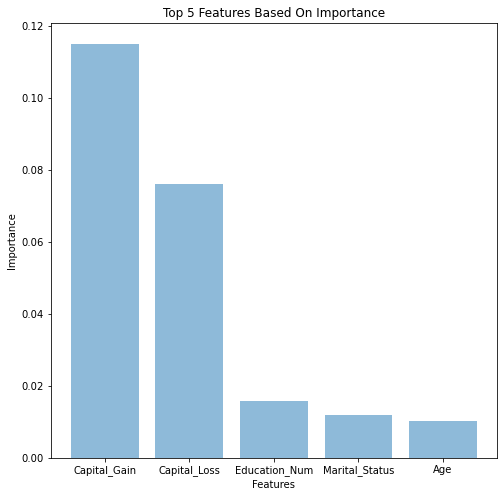

In [25]:
# Naive Bayes Classification
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(training_inputs, training_class_labels)

# Training_data accuracy
estimated_training_output = naive_bayes_classifier.predict(training_inputs)
print('Accuracy on training dataset (Naive-Bayes):\t', naive_bayes_classifier.score(training_inputs, training_class_labels))

# Testing_data accuracy
estimated_testing_output = naive_bayes_classifier.predict(testing_inputs)
print('Accuracy on testing dataset (Naive-Bayes):\t', naive_bayes_classifier.score(testing_inputs, testing_output))

print()
naive_bayes_classifier_report = classification_report(testing_output, estimated_testing_output)
naive_bayes_classifier_report_dict = classification_report(testing_output, estimated_testing_output, output_dict=True)
print(naive_bayes_classifier_report)

# Find feature importance
imps = permutation_importance(naive_bayes_classifier, testing_inputs, estimated_testing_output)['importances_mean']
dic = {}
features = ['Age', 'WorkClass', 'Fnlwgt', 'Education', 'Education_Num', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Week', 'Native_Country']
for i in range(14):
    try:
        if features[i] not in dic:
            dic[features[i]] = imps[i]
    except KeyError: 
        continue 
    
dic = list(sorted(dic.items(), key=lambda x: x[1], reverse=True))
# print(dic[:5])

# Plot the feature importances
all_features = [feature for feature, importance in dic[:5]]
y_pos = np.arange(len(all_features))
importances = [importance for feature, importance in dic[:5]]

plt.bar(y_pos, importances, align='center', alpha=0.5)
plt.xticks(y_pos, all_features)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 5 Features Based On Importance')

plt.show()

Support Vector Machine(SVM)

In [26]:
svm_classifier = SVC() #'RBF' as default model
svm_classifier.fit(training_inputs, training_class_labels)

# Training_data accuracy
estimated_training_output = svm_classifier.predict(training_inputs)
print('Accuracy on training dataset (SVM):\t', svm_classifier.score(training_inputs, training_class_labels))

# Testing_data accuracy
estimated_testing_output = svm_classifier.predict(testing_inputs)
print('Accuracy on testing dataset (SVM):\t', svm_classifier.score(testing_inputs, testing_output))

print()
svm_classifier_report = classification_report(testing_output, estimated_testing_output)
svm_classifier_report_dict = classification_report(testing_output, estimated_testing_output, output_dict=True)
print(svm_classifier_report)

# Find feature importance
# This SVM is not a Linear model. In fact, for the rbf kernel the transformed space is infinite-dimensional.
# If you really want to find out the feature importances, you can try dropping some features and check the accuracy score to play with it.

Accuracy on training dataset (SVM):	 0.8525296730986008
Accuracy on testing dataset (SVM):	 0.8460159362549801

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     11360
           1       0.75      0.55      0.64      3700

    accuracy                           0.85     15060
   macro avg       0.81      0.75      0.77     15060
weighted avg       0.84      0.85      0.84     15060



Linear SVM

Accuracy on training dataset (Linear SVM):	 0.8195079901863271
Accuracy on testing dataset (Linear SVM):	 0.8204515272244356

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     11360
           1       0.73      0.42      0.54      3700

    accuracy                           0.82     15060
   macro avg       0.78      0.69      0.71     15060
weighted avg       0.81      0.82      0.80     15060



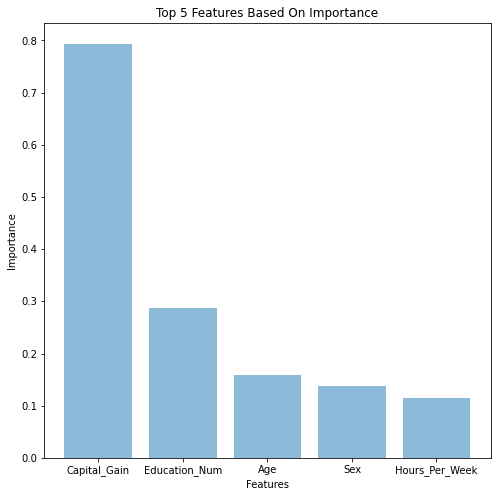

In [27]:
svm_classifier = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
svm_classifier.fit(training_inputs, training_class_labels)

# Training_data accuracy
estimated_training_output = svm_classifier.predict(training_inputs)
print('Accuracy on training dataset (Linear SVM):\t', svm_classifier.score(training_inputs, training_class_labels))

# Testing_data accuracy
estimated_testing_output = svm_classifier.predict(testing_inputs)
print('Accuracy on testing dataset (Linear SVM):\t', svm_classifier.score(testing_inputs, testing_output))

print()
linear_svm_classifier_report = classification_report(testing_output, estimated_testing_output)
linear_svm_classifier_report_dict = classification_report(testing_output, estimated_testing_output, output_dict=True)
print(linear_svm_classifier_report)

# Find feature importances
coef = svm_classifier.coef_[0]
dic = {}
features = ['Age', 'WorkClass', 'Fnlwgt', 'Education', 'Education_Num', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Week', 'Native_Country']
for i in range(14):
    try:
        if features[i] not in dic:
            dic[features[i]] = coef[i]
    except KeyError: 
        continue 
    
dic = list(sorted(dic.items(), key=lambda x: x[1], reverse=True))
# print(dic[:5])

# Plot the feature importances
all_features = [feature for feature, importance in dic[:5]]
y_pos = np.arange(len(all_features))
importances = [importance for feature, importance in dic[:5]]

plt.bar(y_pos, importances, align='center', alpha=0.5)
plt.xticks(y_pos, all_features)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 5 Features Based On Importance')

plt.show()

Logistic Regression

Accuracy on training dataset (Logistic Regression):	 0.8205026191897089
Accuracy on testing dataset (Logistic Regression):	 0.8202523240371846

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     11360
           1       0.71      0.45      0.55      3700

    accuracy                           0.82     15060
   macro avg       0.78      0.70      0.72     15060
weighted avg       0.81      0.82      0.81     15060



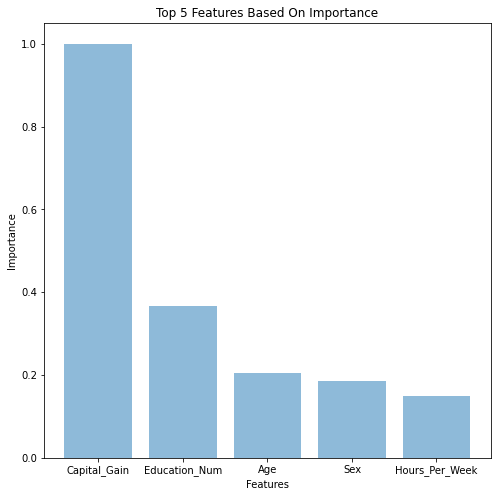

In [28]:
logistic_classifier = LogisticRegression(random_state=0)
logistic_classifier.fit(training_inputs, training_class_labels)

# Training_data accuracy
estimated_training_output = logistic_classifier.predict(training_inputs)
print('Accuracy on training dataset (Logistic Regression):\t', logistic_classifier.score(training_inputs, training_class_labels))

# Testing_data accuracy
estimated_testing_output = logistic_classifier.predict(testing_inputs)
print('Accuracy on testing dataset (Logistic Regression):\t', logistic_classifier.score(testing_inputs, testing_output))

print()
logistic_classifier_report = classification_report(testing_output, estimated_testing_output)
logistic_classifier_report_dict = classification_report(testing_output, estimated_testing_output, output_dict=True)
print(logistic_classifier_report)

# Find feature importances
coef = abs(logistic_classifier.coef_[0])
coef = (coef / coef.max())
dic = {}
features = ['Age', 'WorkClass', 'Fnlwgt', 'Education', 'Education_Num', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Week', 'Native_Country']
for i in range(14):
    try:
        if features[i] not in dic:
            dic[features[i]] = coef[i]
    except KeyError: 
        continue 
    
dic = list(sorted(dic.items(), key=lambda x: x[1], reverse=True))
# print(dic[:5])

# Plot the feature importances
all_features = [feature for feature, importance in dic[:5]]
y_pos = np.arange(len(all_features))
importances = [importance for feature, importance in dic[:5]]

plt.bar(y_pos, importances, align='center', alpha=0.5)
plt.xticks(y_pos, all_features)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 5 Features Based On Importance')

plt.show()

K-nearest_neighboor (KNN)

Accuracy on training dataset (KNN):	 0.9999668456998873
Accuracy on testing dataset (KNN):	 0.8289508632138114

              precision    recall  f1-score   support

           0       0.86      0.92      0.89     11360
           1       0.70      0.54      0.61      3700

    accuracy                           0.83     15060
   macro avg       0.78      0.73      0.75     15060
weighted avg       0.82      0.83      0.82     15060



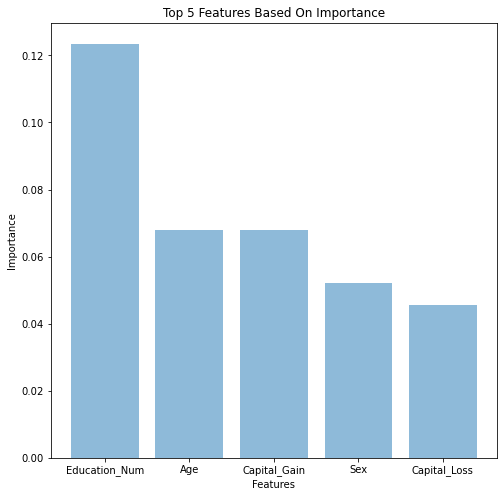

In [29]:
knn_classifier = KNeighborsClassifier(n_neighbors=100, weights='distance')
knn_classifier.fit(training_inputs, training_class_labels)

# Training_data accuracy
estimated_training_output = knn_classifier.predict(training_inputs)
print('Accuracy on training dataset (KNN):\t', knn_classifier.score(training_inputs, training_class_labels))

# Testing_data accuracy
estimated_testing_output = knn_classifier.predict(testing_inputs)
print('Accuracy on testing dataset (KNN):\t', knn_classifier.score(testing_inputs, testing_output))

print()
knn_classifier_report = classification_report(testing_output, estimated_testing_output)
knn_classifier_report_dict = classification_report(testing_output, estimated_testing_output, output_dict=True)
print(knn_classifier_report)


# Find feature importances
reg = LassoCV()
reg.fit(training_inputs, training_class_labels)
coef = reg.coef_
# print(coef)

dic = {}
features = ['Age', 'WorkClass', 'Fnlwgt', 'Education', 'Education_Num', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Week', 'Native_Country']

for i in range(14):
    try:
        if features[i] not in dic:
            dic[features[i]] = coef[i]
    except KeyError: 
        continue 
    
dic = list(sorted(dic.items(), key=lambda x: x[1], reverse=True))
# print(dic[:5])

# Plot the feature importances
all_features = [feature for feature, importance in dic[:5]]
y_pos = np.arange(len(all_features))
importances = [importance for feature, importance in dic[:5]]

plt.bar(y_pos, importances, align='center', alpha=0.5)
plt.xticks(y_pos, all_features)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 5 Features Based On Importance')

plt.show()

Decision Tree

Accuracy on training dataset (Decision Tree):	 0.9999668456998873
Accuracy on testing dataset (Decision Tree):	 0.8075033200531209

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     11360
           1       0.61      0.61      0.61      3700

    accuracy                           0.81     15060
   macro avg       0.74      0.74      0.74     15060
weighted avg       0.81      0.81      0.81     15060

[('Fnlwgt', 0.21597474801323505), ('Relationship', 0.19495783042492923), ('Age', 0.1292461613643615), ('Capital_Gain', 0.10396911023335918), ('Education_Num', 0.0999932101181927)]


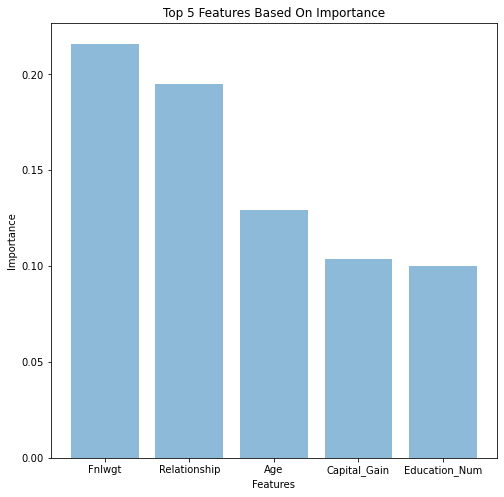

In [30]:
dt_classifier = DecisionTreeClassifier(random_state=0, splitter='best', criterion='entropy')
dt_classifier.fit(training_inputs, training_class_labels)

# Training_data accuracy
estimated_training_output = dt_classifier.predict(training_inputs)
print('Accuracy on training dataset (Decision Tree):\t', dt_classifier.score(training_inputs, training_class_labels))

# Testing_data accuracy
estimated_testing_output = dt_classifier.predict(testing_inputs)
print('Accuracy on testing dataset (Decision Tree):\t', dt_classifier.score(testing_inputs, testing_output))

print()
dt_classifier_report = classification_report(testing_output, estimated_testing_output)
dt_classifier_report_dict = classification_report(testing_output, estimated_testing_output, output_dict=True)
print(dt_classifier_report)


# Find feature importances
scores = dt_classifier.feature_importances_
dic = {}
features = ['Age', 'WorkClass', 'Fnlwgt', 'Education', 'Education_Num', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Week', 'Native_Country']

for i in range(14):
    try:
        if features[i] not in dic:
            dic[features[i]] = scores[i]
    except KeyError: 
        continue 
    
dic = list(sorted(dic.items(), key=lambda x: x[1], reverse=True))
# print(dic[:5])

# Plot the feature importances
all_features = [feature for feature, importance in dic[:5]]
y_pos = np.arange(len(all_features))
importances = [importance for feature, importance in dic[:5]]

plt.bar(y_pos, importances, align='center', alpha=0.5)
plt.xticks(y_pos, all_features)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 5 Features Based On Importance')

plt.show()

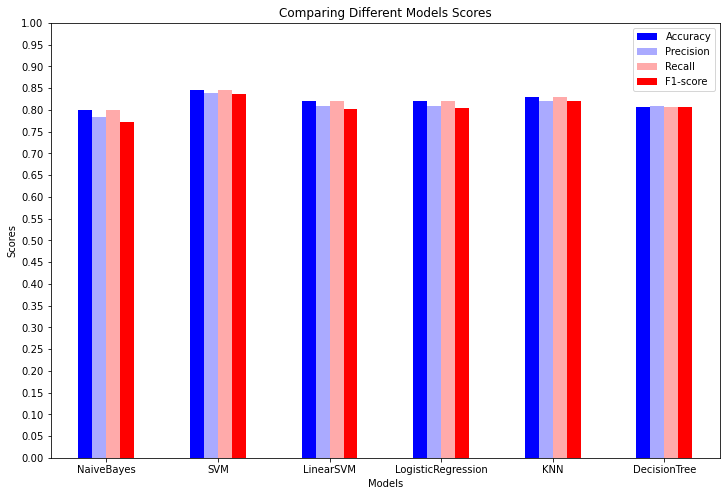

In [32]:
# Plot all 6 classifiers with their report

# Naive Bayes Classifier
naive_bayes_result = ['NaiveBayes']
naive_bayes_result.append(naive_bayes_classifier_report_dict['accuracy'])
naive_bayes_result.append(naive_bayes_classifier_report_dict['weighted avg']['precision'])
naive_bayes_result.append(naive_bayes_classifier_report_dict['weighted avg']['recall'])
naive_bayes_result.append(naive_bayes_classifier_report_dict['weighted avg']['f1-score'])

# SVM Classifier
svm_result = ['SVM']
svm_result.append(svm_classifier_report_dict['accuracy'])
svm_result.append(svm_classifier_report_dict['weighted avg']['precision'])
svm_result.append(svm_classifier_report_dict['weighted avg']['recall'])
svm_result.append(svm_classifier_report_dict['weighted avg']['f1-score'])

# Linear SVM Classifier
linear_SVM_result = ['LinearSVM']
linear_SVM_result.append(linear_svm_classifier_report_dict['accuracy'])
linear_SVM_result.append(linear_svm_classifier_report_dict['weighted avg']['precision'])
linear_SVM_result.append(linear_svm_classifier_report_dict['weighted avg']['recall'])
linear_SVM_result.append(linear_svm_classifier_report_dict['weighted avg']['f1-score'])

# Logistic Classifier Classifier
logistic_result = ['LogisticRegression']
logistic_result.append(logistic_classifier_report_dict['accuracy'])
logistic_result.append(logistic_classifier_report_dict['weighted avg']['precision'])
logistic_result.append(logistic_classifier_report_dict['weighted avg']['recall'])
logistic_result.append(logistic_classifier_report_dict['weighted avg']['f1-score'])

# KNN Classifier
knn_result = ['KNN']
knn_result.append(knn_classifier_report_dict['accuracy'])
knn_result.append(knn_classifier_report_dict['weighted avg']['precision'])
knn_result.append(knn_classifier_report_dict['weighted avg']['recall'])
knn_result.append(knn_classifier_report_dict['weighted avg']['f1-score'])

# Decision Tree Classifier
dt_result = ['DecisionTree']
dt_result.append(dt_classifier_report_dict['accuracy'])
dt_result.append(dt_classifier_report_dict['weighted avg']['precision'])
dt_result.append(dt_classifier_report_dict['weighted avg']['recall'])
dt_result.append(dt_classifier_report_dict['weighted avg']['f1-score'])

# Put them altogether
results = [naive_bayes_result, svm_result, linear_SVM_result, logistic_result, knn_result, dt_result]
results_df = pd.DataFrame(results, columns =['Model','Accuracy','Precision','Recall','F1-score'])

#Plotting results
results_df.plot(kind ='bar',figsize=(12,8), colormap='bwr')
plt.xticks(range(len(results_df)), results_df.iloc[:,0].tolist(),rotation=0)
plt.yticks(np.arange(0,1.05,0.05))
plt.xlabel("Models")
plt.ylabel("Scores")
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Comparing Different Models Scores")
plt.show()